# Analising the RAW data

In [12]:
import librosa
import os
import csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

To go to our dataset and classify the sounds by duration of the clips in seconds
0 - 8s SHORT
8 - 12s MEDIUM
above 12s - LONG

In [19]:
SHORT_LIMIT = 8  # seconds
MEDIUM_LIMIT = 12

# Path to the audio folder (going one level up to access the 'dataset' folder)
audio_folder = '../dataset'

# Function to label the duration
def label_duration(duration):
    if duration <= SHORT_LIMIT:
        return 'short'
    elif SHORT_LIMIT < duration <= MEDIUM_LIMIT:
        return 'medium'
    else:
        return 'long'
    
# Create a list to store the audio information
audio_data = []

# Iterate through all audio files in the folder
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):  
        file_path = os.path.join(audio_folder, filename)
        # Load the audio file and calculate its duration
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        # Append the file name, duration, and corresponding label to the list
        audio_data.append([filename, duration, label_duration(duration)])

# Save the data to a CSV file
csv_file = 'audio_durations_labels.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['file_name', 'duration_seconds', 'label'])
    # Write the data rows
    writer.writerows(audio_data)

print(f'Data saved in {csv_file}')

Data saved in audio_durations_labels.csv


Visualizing the data

In [2]:
# Load the CSV into a pandas DataFrame
csv_file = 'audio_durations_labels.csv'
df = pd.read_csv(csv_file)

# Show the first few rows of the DataFrame
print(df.head())

      File Name  Duration (seconds)   Label
0  IMG_6969.wav            3.400000   short
1  IMG_6955.wav           13.030023    long
2  IMG_6941.wav            8.780000  medium
3  IMG_6772.wav           18.310023    long
4  IMG_9327.wav           13.530023    long


Bar plot to see the amount of data per class

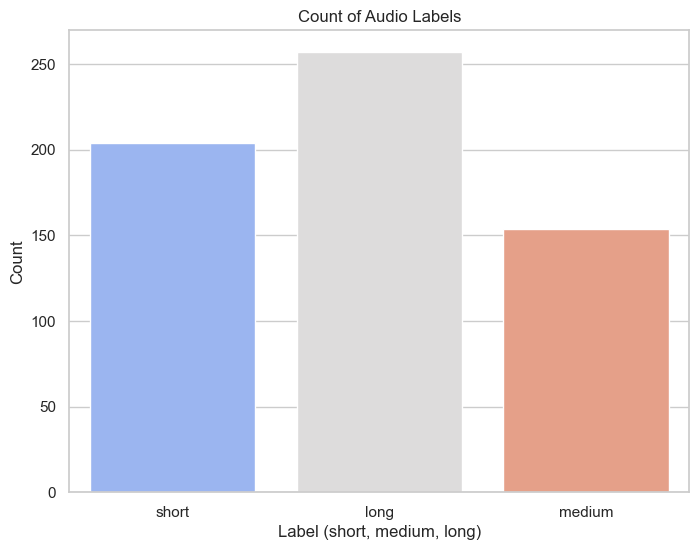

In [4]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Bar plot to show the count of each label
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df, hue='Label', palette='coolwarm', legend=False)
plt.title('Count of Audio Labels')
plt.xlabel('Label (short, medium, long)')
plt.ylabel('Count')
plt.show()

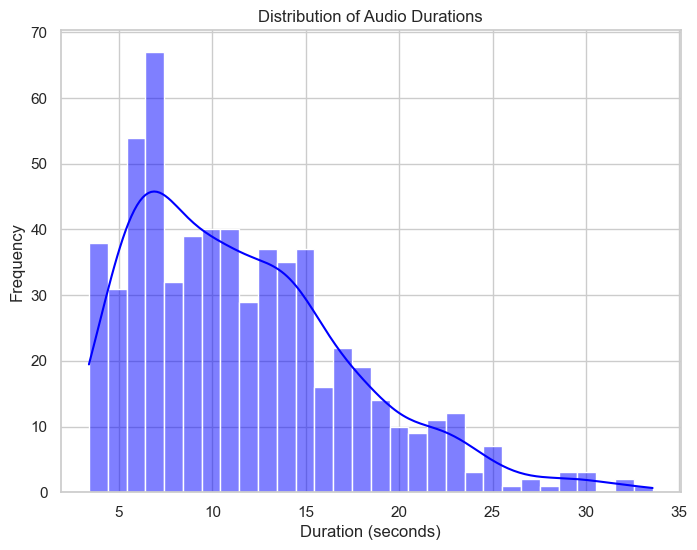

In [5]:
# Histogram to show the distribution of audio durations
plt.figure(figsize=(8, 6))
sns.histplot(df['duration_seconds'], bins=30, kde=True, color='blue')
plt.title('Distribution of Audio Durations')
plt.xlabel('duration_seconds)')
plt.ylabel('Frequency')
plt.show()

Swarm plot: A swarm plot can show the distribution of audio durations for each label (short, medium, long)

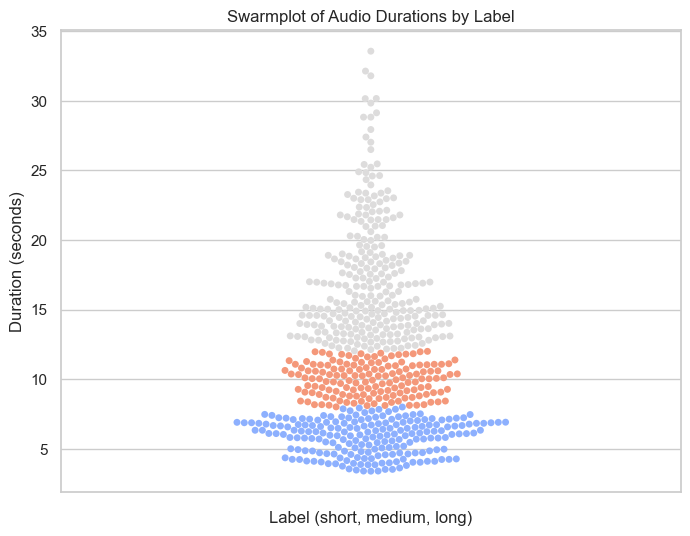

In [9]:
plt.figure(figsize=(8, 6))
sns.swarmplot(hue='Label', y='duration_seconds)', data=df, palette='coolwarm', legend=False)
plt.title('Swarmplot of Audio Durations by Label')
plt.xlabel('Label (short, medium, long)')
plt.ylabel('duration_seconds)')
plt.show()


# More features to visualize

## 1. Amplitude (Max Amplitude or Average Amplitude):
**What it is**: Amplitude represents the "intensity" or "loudness" of an audio signal. In digital audio, this is usually the height of the audio waveform at any given point. For example, higher amplitude means louder sounds, while lower amplitude means quieter sounds.

**How we calculate it**: In the code, we extract the maximum amplitude using `np.max(np.abs(y))`, which finds the highest value of the waveform. We could also calculate the average amplitude using `np.mean(np.abs(y))`, which would give a measure of the average loudness.

**Range of values**: Typically, in digital audio, the amplitude is normalized between -1 and 1, where 1 represents the maximum loudness without distortion. The values are absolute, so after taking the max or average, they will be between 0 and 1.

**Typical use**: Amplitude can be useful in understanding the energy of the audio. For example, pouring water faster might result in louder sounds, represented by a higher max amplitude.

---

## 2. Frequency Analysis (FFT):
**What it is**: The Fast Fourier Transform (FFT) is a mathematical process that transforms the audio signal from the time domain into the frequency domain. In the frequency domain, the audio signal is represented as a sum of different sine and cosine waves, each with a specific frequency and amplitude.

**How we calculate it**: We use `np.fft.fft(y)` to compute the FFT of the audio signal y. This gives us an array of complex numbers representing the amplitude and phase of each frequency component. We extract the dominant frequency by finding the frequency with the highest magnitude.

**Range of values**: The frequency is measured in Hertz (Hz). Human hearing typically ranges from 20 Hz to 20,000 Hz, so you can expect the dominant frequencies of the pouring water sounds to be within this range, often in the lower spectrum (around hundreds to low thousands of Hz).

**Typical use**: Frequency analysis helps us understand the pitch or tonal content of the sound. Different pouring speeds could result in different dominant frequencies.

---

## 3. Spectral Centroid:
**What it is**: The spectral centroid indicates the "center of mass" of the spectrum, which is a way of describing where the "center" of the sound frequencies is located. A higher spectral centroid typically means the sound is "brighter" (more high frequencies), while a lower spectral centroid means the sound is "darker" or "muddier" (more low frequencies).

**How we calculate it**: We use `librosa.feature.spectral_centroid` to calculate the spectral centroid of the audio signal. This function returns the mean of all the frequencies weighted by their magnitudes.

**Range of values**: The spectral centroid is also measured in Hertz (Hz). Like the FFT, you might expect spectral centroid values to range from low hundreds to a few thousand Hertz, depending on the characteristics of the pouring sounds.

**Typical use**: The spectral centroid is useful in classifying sounds. Faster or more turbulent water pouring might produce a "brighter" sound with a higher spectral centroid, while slower pours might result in lower centroids.

---

## 4. Zero Crossing Rate:
**What it is**: The zero-crossing rate measures how often the audio signal waveform crosses the zero point (i.e., changes from positive to negative values) within a given time frame. It is often used to analyze the noisiness or texture of a sound.

**How we calculate it**: We use `librosa.feature.zero_crossing_rate` to calculate the zero-crossing rate of the audio signal y. This gives us the average number of zero crossings per frame.

**Range of values**: The zero-crossing rate is a normalized value between 0 and 1, where higher values mean the audio has more rapid fluctuations (such as noise or fricatives in speech), and lower values mean smoother, less fluctuating signals.

**Typical use**: Sounds like water pouring can have varying zero-crossing rates depending on the speed or surface of the water. Higher zero-crossing rates might indicate more turbulence or a more complex sound pattern.


In [15]:
# Function to extract audio features
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)

    # 1. Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # 2. Amplitude (maximum amplitude)
    amplitude_max = np.max(np.abs(y))

    # 3. FFT (Frequency Analysis)
    fft = np.fft.fft(y)
    magnitude = np.abs(fft)
    frequency = np.fft.fftfreq(len(magnitude), 1/sr)
    # Get the dominant frequency
    dominant_frequency = frequency[np.argmax(magnitude)]

    # 4. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

    # 5. Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

    # Return all features as a dictionary
    return {
        'duration': duration,
        'amplitude_max': amplitude_max,
        'dominant_frequency': dominant_frequency,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate
    }

# Create a list to store the audio information
audio_features = []

# Iterate through all audio files in the folder
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'): 
        file_path = os.path.join(audio_folder, filename)
        features = extract_features(file_path)
        # Append the features along with the filename
        features['file_name'] = filename
        audio_features.append(features)

# Convert the features list into a pandas DataFrame
df = pd.DataFrame(audio_features)

# Show the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file
csv_file = 'audio_features.csv'
df.to_csv(csv_file, index=False)

print(f'Features saved to {csv_file}')

    duration  amplitude_max  dominant_frequency  spectral_centroid  \
0   3.400000       0.110510           54.705882        2693.875832   
1  13.030023       0.131408          101.841726        2400.584924   
2   8.780000       0.107243          102.733485        2363.703953   
3  18.310023       0.596768           49.371867        2378.741314   
4  13.530023       0.336703          131.115819        2262.181480   

   zero_crossing_rate     file_name  
0            0.120811  IMG_6969.wav  
1            0.112325  IMG_6955.wav  
2            0.105469  IMG_6941.wav  
3            0.084683  IMG_6772.wav  
4            0.114526  IMG_9327.wav  
Features saved to audio_features.csv


Combining both tables

In [20]:
# Load the audio features CSV
features_df = pd.read_csv('audio_features.csv')

# Load the short, medium, long labels CSV
labels_df = pd.read_csv('audio_durations_labels.csv')

# Merge the two dataframes on the file name
combined_df = pd.merge(features_df, labels_df, on='file_name')

# Show the combined dataframe
print(combined_df.head())

# Save the combined data to a new CSV
combined_df.to_csv('combined_audio_data.csv', index=False)

print(f'Combined data saved to combined_audio_data.csv')


    duration  amplitude_max  dominant_frequency  spectral_centroid  \
0   3.400000       0.110510           54.705882        2693.875832   
1  13.030023       0.131408          101.841726        2400.584924   
2   8.780000       0.107243          102.733485        2363.703953   
3  18.310023       0.596768           49.371867        2378.741314   
4  13.530023       0.336703          131.115819        2262.181480   

   zero_crossing_rate     file_name  duration_seconds   label  
0            0.120811  IMG_6969.wav          3.400000   short  
1            0.112325  IMG_6955.wav         13.030023    long  
2            0.105469  IMG_6941.wav          8.780000  medium  
3            0.084683  IMG_6772.wav         18.310023    long  
4            0.114526  IMG_9327.wav         13.530023    long  
Combined data saved to combined_audio_data.csv


# Pair plot for all numerical features, colored by label

**Objective**: Create a graph that shows the relationship between all features and colors the points according to their duration label.

**Insight**: Identify correlations between features and how they group by label.

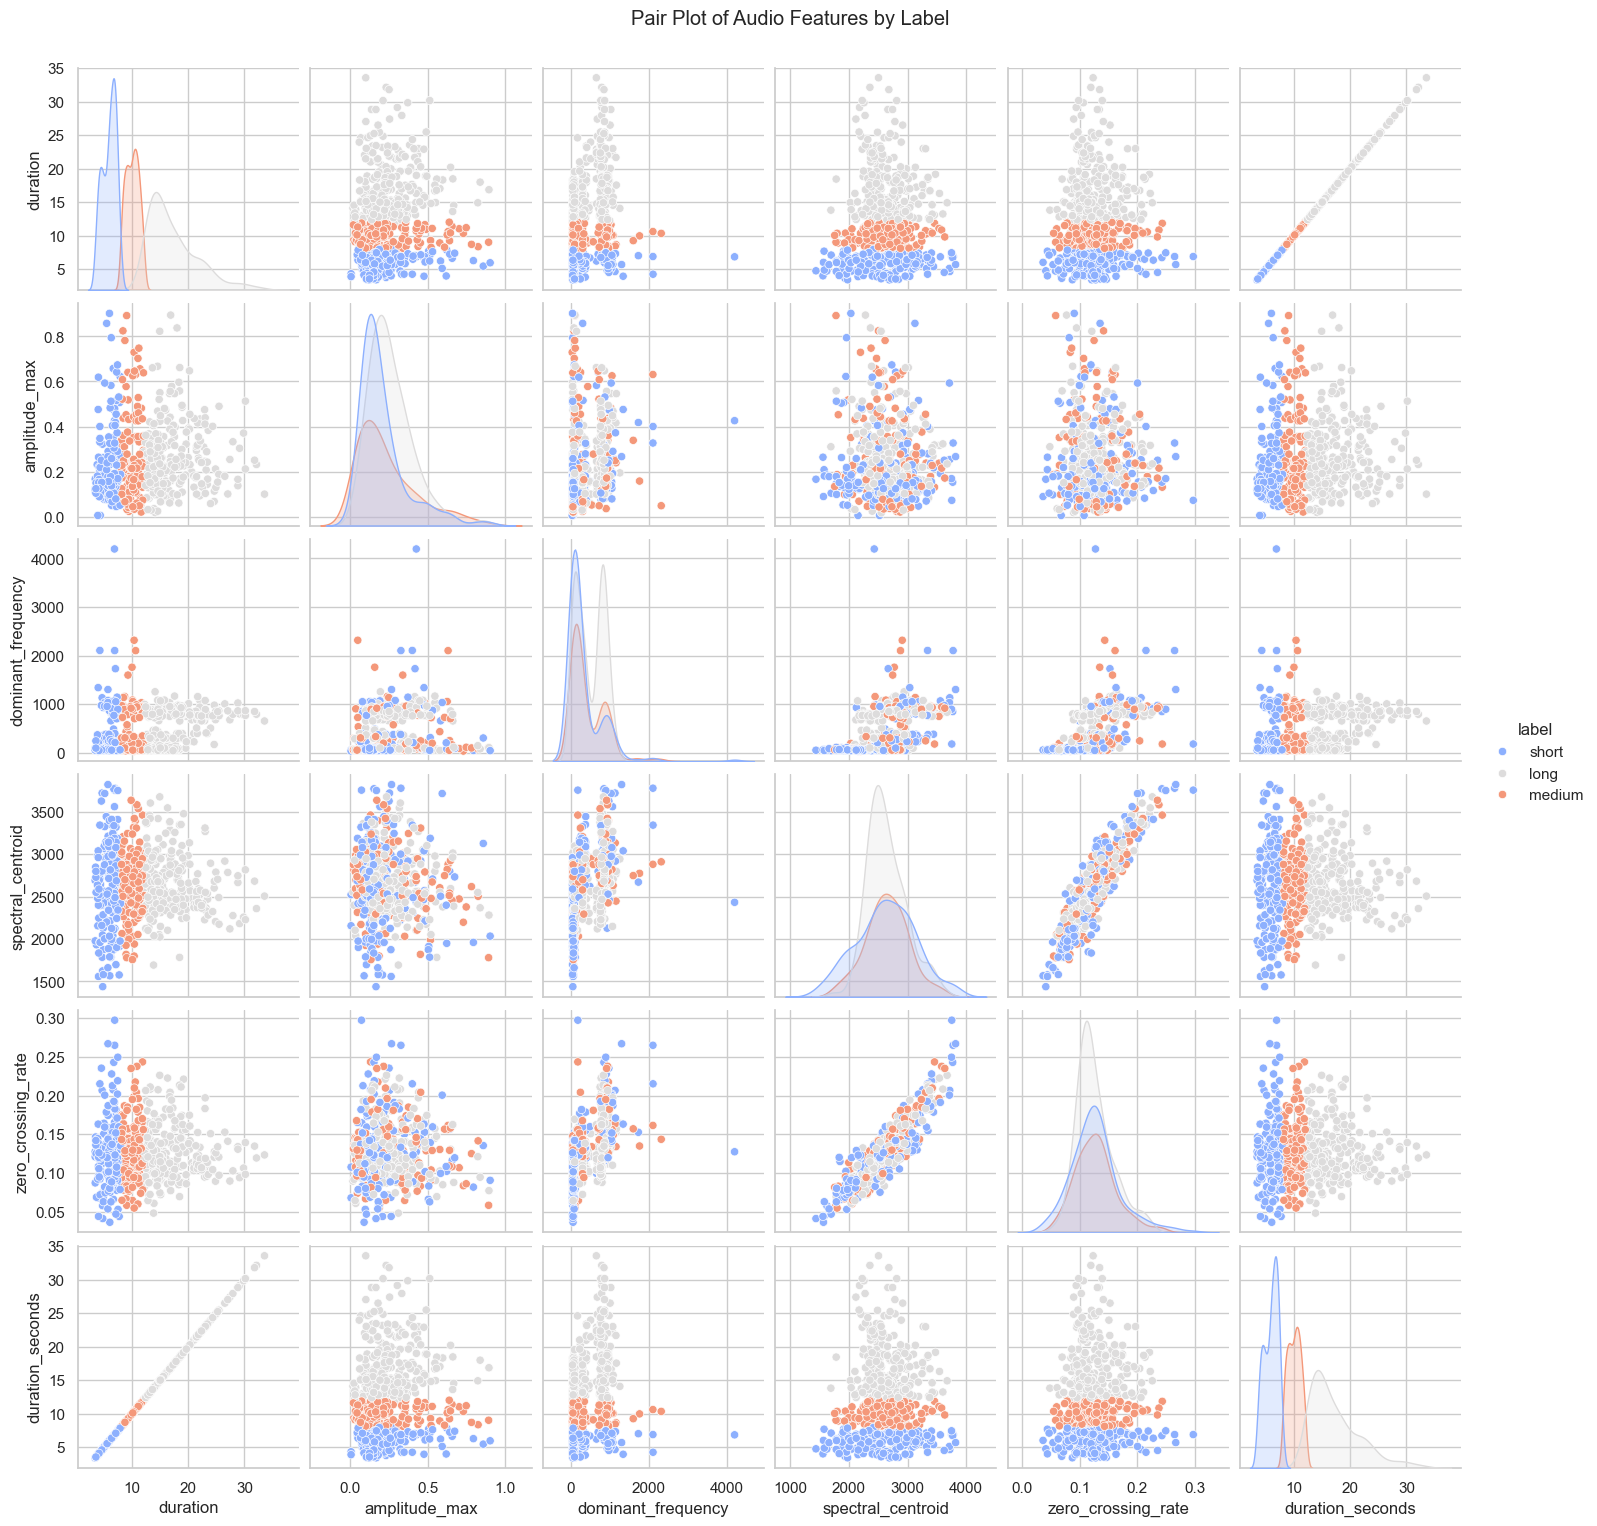

In [26]:
sns.pairplot(combined_df, hue='label', palette='coolwarm')
plt.suptitle('Pair Plot of Audio Features by Label', y=1.02)
plt.show()

# Histograms

**Objective**: Show the distribution of each feature separately for each label.

**Insight**: Examine how feature values ​​are distributed within each duration category.

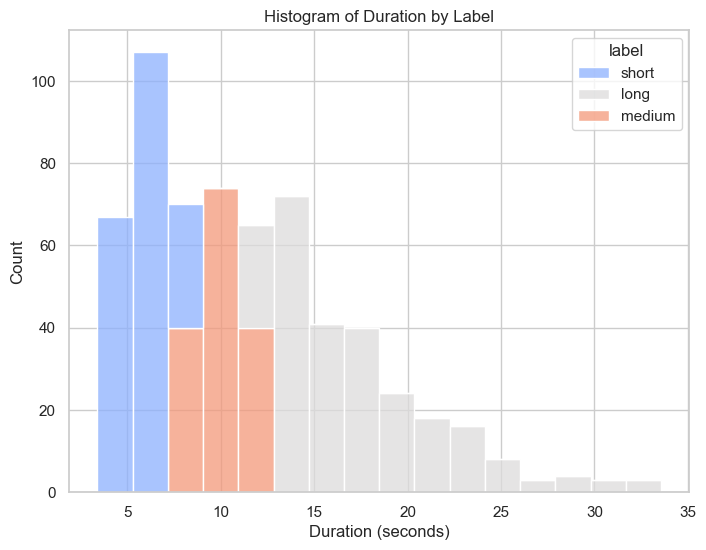

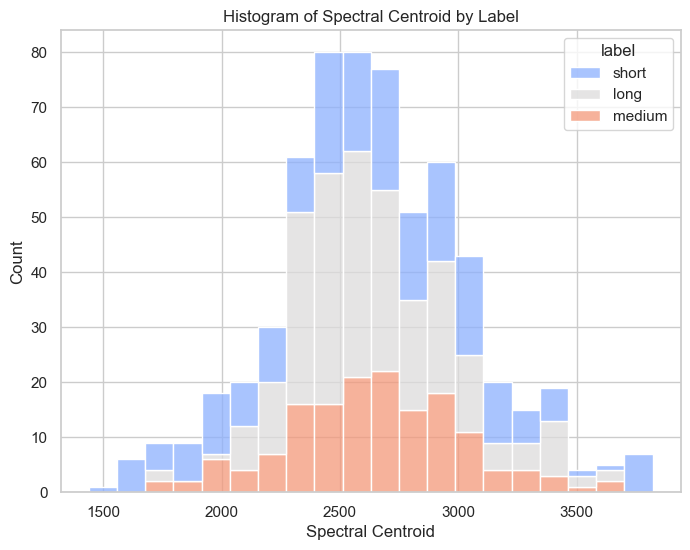

In [27]:
# Histogram for duration_seconds
plt.figure(figsize=(8, 6))
sns.histplot(data=combined_df, x='duration_seconds', hue='label', multiple='stack', palette='coolwarm')
plt.title('Histogram of Duration by Label')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

# Histogram for spectral_centroid
plt.figure(figsize=(8, 6))
sns.histplot(data=combined_df, x='spectral_centroid', hue='label', multiple='stack', palette='coolwarm')
plt.title('Histogram of Spectral Centroid by Label')
plt.xlabel('Spectral Centroid')
plt.ylabel('Count')
plt.show()


# Logistic Regression

**When to use**: When the output variables are categorical (such as short, medium, long). It is a simple and efficient technique for binary or multi-class classification.

**Advantage**: Fast, easy to implement and interpret.

**Applicable**: Since our problem has three classes, we can use a multinomial logistic regression.

In [1]:
import librosa
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Path to the dataset
audio_folder = '../dataset'

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # 1. Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # 2. Amplitude (maximum amplitude)
    amplitude_max = np.max(np.abs(y))

    # 3. FFT (Frequency Analysis)
    fft = np.fft.fft(y)
    magnitude = np.abs(fft)
    frequency = np.fft.fftfreq(len(magnitude), 1/sr)
    dominant_frequency = frequency[np.argmax(magnitude)]

    # 4. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

    # 5. Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

    # Return all features as a list
    return [duration, amplitude_max, dominant_frequency, spectral_centroid, zero_crossing_rate]

# Create lists to store file names and their corresponding features
audio_features = []
labels = []

# Assuming you have a separate CSV file with the labels for each file
labels_df = pd.read_csv('audio_durations_labels.csv')  # Load the labels CSV

# Iterate through all audio files in the dataset folder
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):  # Make sure to adjust if the files are different
        file_path = os.path.join(audio_folder, filename)
        # Extract features from the audio file
        features = extract_features(file_path)
        # Find the label from the labels_df for this file
        label = labels_df[labels_df['file_name'] == filename]['label'].values[0]
        
        # Append the features and label
        audio_features.append(features)
        labels.append(label)

# Convert the audio features and labels into a DataFrame
features_df = pd.DataFrame(audio_features, columns=['duration', 'amplitude_max', 'dominant_frequency', 'spectral_centroid', 'zero_crossing_rate'])
features_df['label'] = labels

# Prepare the features (X) and labels (y)
X = features_df[['amplitude_max', 'dominant_frequency', 'spectral_centroid', 'zero_crossing_rate']]  # You can include/exclude any feature
y = features_df['label']

# Encode the labels (short, medium, long) into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Accuracy: 0.4864864864864865

Classification Report:
               precision    recall  f1-score   support

        long       0.44      0.91      0.60        70
      medium       0.00      0.00      0.00        42
       short       0.63      0.36      0.46        73

    accuracy                           0.49       185
   macro avg       0.36      0.42      0.35       185
weighted avg       0.42      0.49      0.41       185



/opt/homebrew/Caskroom/miniforge/base/envs/aicp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aicp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aicp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf